In [1]:
# Librerias utilizadas.
## Importación de datos.
from sqlalchemy import create_engine
## Tratamiento de datos.
import pandas as pd
import numpy as np
## Gráficos.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10
## Preprocesado y modelado.
from sklearn import datasets, linear_model, metrics, svm, preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
## Configuración warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Nombre de usuario, contraseña y BBDD MySQL.
mysql_address = 'xxx.xxx.xxx.xxx'
mysql_port = 'xxx'
mysql_username = 'xxx'
mysql_password = 'xxx'
mysql_dbname = 'xxx'
# String que contiene la información necesaria para el login de MySQL.
mysql_str = ('mysql+pymysql://{username}:{password}@{ipaddress}:{port}/{dbname}'
.format(username = mysql_username,
password = mysql_password,
ipaddress = mysql_address,
port = mysql_port,
dbname = mysql_dbname))

In [3]:
# Query para importar los datos desde MySQL.
cnx = create_engine(mysql_str)
query = f"""
/*HOANG*/
SELECT
    matches.duration_minutes AS 'duration',
    players.civ,
    players.won
FROM
    matches, players
WHERE
    matches.match_id = players.match_id
AND
    matches.map_type = 'Arabia'
AND
    matches.rating_type = '1v1 Random Map'
AND
    players.profile_id = '459658';
"""
df = pd.read_sql_query(query, con=cnx)
df.shape

(1165, 3)

In [4]:
df.head(10)

,duration,civ,won
0,26,Celts,1
1,3,Celts,1
2,22,Celts,1
3,16,Celts,1
4,14,Celts,1
5,15,Celts,1
6,16,Celts,1
7,11,Celts,1
8,25,Celts,1
9,16,Celts,0


In [5]:
df.tail(10)

,duration,civ,won
1155,15,Celts,1
1156,24,Celts,1
1157,14,Celts,0
1158,29,Celts,1
1159,14,Celts,1
1160,23,Celts,0
1161,27,Celts,1
1162,14,Celts,1
1163,24,Celts,1
1164,22,Celts,0


In [6]:
# Comprobación de valores NaN en el dataset.
df.isna().sum()

duration    0
civ         0
won         0
dtype: int64

In [7]:
# Eliminar registros donde la variable "rating" es NaN.
df.dropna(inplace=True)
df.shape

(1165, 3)

In [8]:
# Convertir variables object a category.
df['civ']           = df['civ'].astype('category')

In [9]:
# Comprobación de cada tipo de variable.
df.dtypes

duration       int64
civ         category
won            int64
dtype: object

In [10]:
# Estadísticos básicos de las variables numéricas.
df.describe()

,duration,won
count,1165.000000,1165.000000
mean,19.433476,0.567382
std,7.805083,0.495652
min,0.000000,0.000000
25%,14.000000,0.000000
50%,18.000000,1.000000
75%,24.000000,1.000000
max,58.000000,1.000000


<AxesSubplot:xlabel='duration', ylabel='Density'>

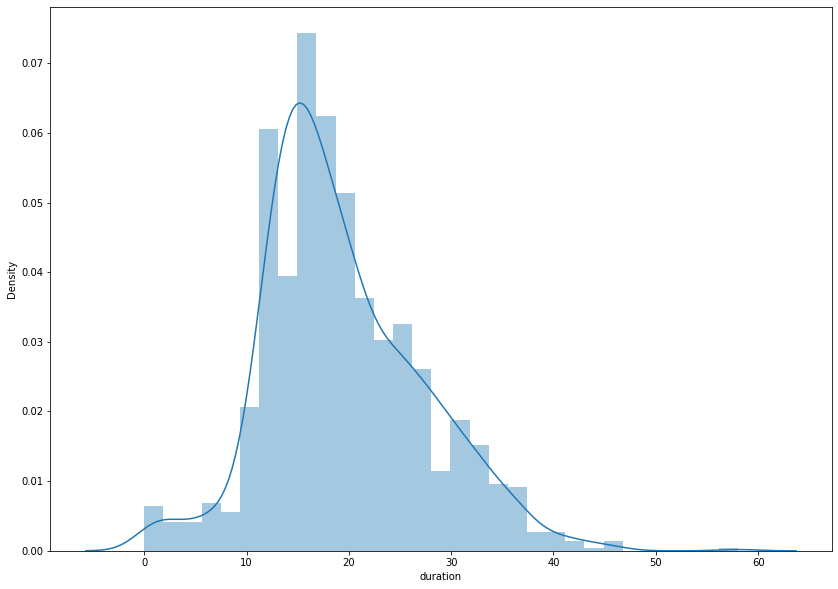

In [11]:
sns.distplot(df.duration)

<AxesSubplot:xlabel='duration'>

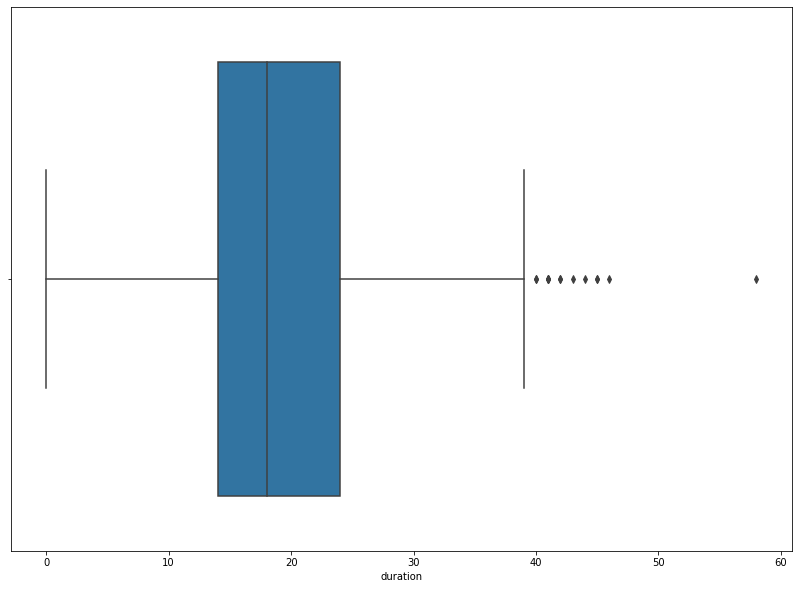

In [12]:
sns.boxplot(df.duration)

In [13]:
# Valores únicos de la variable "civ".
civs = df.civ.unique().tolist()
civs.sort()
# Creación de la función personalizada "obtener los índices de frecuencia por país".
def get_frequency_rates_by_civ(df):
    return pd.DataFrame(df.civ.value_counts(normalize=True)).reset_index().rename(columns={"index": "civ", "civ": "frequency"})
# Creación de la función personalizada "obtener las tasas de victoria por país".
def get_win_rates_by_civ(df):
    return (
        df.groupby("civ")["won"]
            .mean()
            .reset_index()
            .rename(columns={"won": "win_rate"})
            .sort_values("win_rate", ascending=False)
            .reset_index(drop=True)
    )
# Aplicación de las dos funciones creadas anteriormente.
frequency_rates_civ = get_frequency_rates_by_civ(df)
win_rates_civ              = get_win_rates_by_civ(df)

Text(0.5, 1.0, 'Frecuencia de partidas por civilización')

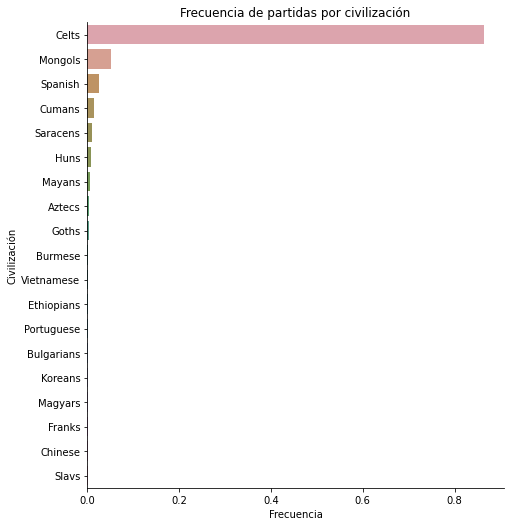

In [14]:
sns.catplot(y="civ",
                        x="frequency", 
                        data=frequency_rates_civ,
                        saturation=0.5,
                        kind="bar",
                        ci=None,
                        aspect=1,
                        height=7,
                        orient="h",
                        order=frequency_rates_civ.sort_values('frequency', ascending=False).civ)
plt.ylabel("Civilización")
plt.xlabel("Frecuencia")
plt.title("Frecuencia de partidas por civilización")

Text(0.5, 1.0, 'Tasa de victorias por civilización')

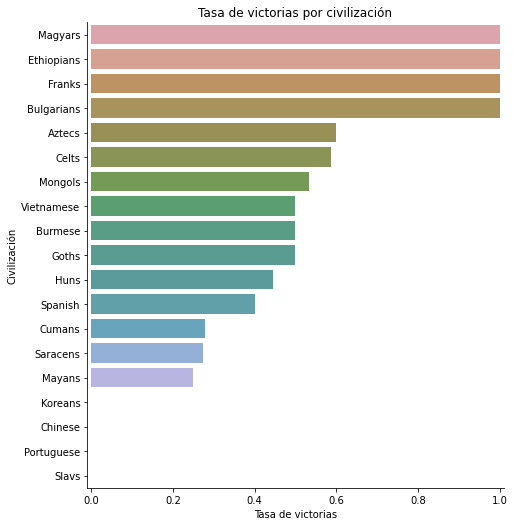

In [15]:
sns.catplot(y="civ",
                        x="win_rate", 
                        data=win_rates_civ,
                        saturation=0.5,
                        kind="bar",
                        ci=None,
                        aspect=1,
                        height=7,
                        orient="h", 
                        order=win_rates_civ.sort_values('win_rate', ascending=False).civ)
plt.ylabel("Civilización")
plt.xlabel("Tasa de victorias")
lim_sup = float(win_rates_civ.win_rate.head(1) + 0.01)
lim_inf = float(win_rates_civ.win_rate.tail(1) - 0.01)
plt.xlim(lim_inf, lim_sup)
plt.title("Tasa de victorias por civilización")

In [16]:
# Función para la creación de variables dummy.
def create_dummies(df, var_name):
    dummy = pd.get_dummies(df[var_name], prefix=var_name)
    df = df.drop(var_name, axis = 1)
    df = pd.concat([df, dummy ], axis = 1)
    return df
# Creación variables dummy.
categorical = ["civ"]
for category in categorical:
    df = create_dummies(df, category)

In [17]:
# Transformación de las entidades escalando cada entidad a un rango determinado.
scaler = MinMaxScaler() 
arr_scaled = scaler.fit_transform(df) 
df_scaled = pd.DataFrame(arr_scaled, columns=df.columns,index=df.index)
df_scaled

,duration,won,civ_Aztecs,civ_Bulgarians,civ_Burmese,civ_Celts,civ_Chinese,civ_Cumans,civ_Ethiopians,civ_Franks,...,civ_Huns,civ_Koreans,civ_Magyars,civ_Mayans,civ_Mongols,civ_Portuguese,civ_Saracens,civ_Slavs,civ_Spanish,civ_Vietnamese
0,0.448276,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.051724,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.379310,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.275862,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.241379,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,0.396552,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1161,0.465517,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1162,0.241379,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1163,0.413793,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Selección de rasgos para el modelo.
features = len(df_scaled.columns.values)
summary_models_logreg = pd.DataFrame(columns=['initial_features', 
                                                                                                       'final_features',
                                                                                                       'aic',
                                                                                                       'bic',
                                                                                                       'df_residuals',
                                                                                                       'r_squared',
                                                                                                       'score_accuracy',
                                                                                                       'roc_auc_score'])
for f in range(4, features, 4):
    print("-------------")
    print("Features:", f)
    # Recursive Feature Elimination
    df_vars=df_scaled.columns.values.tolist()
    y_var=['won']
    X_var=[i for i in df_vars if i not in y_var]
    y = pd.DataFrame(data=df_scaled,columns=y_var)
    X = pd.DataFrame(data=df_scaled,columns=X_var)
    logreg_sklearn = LogisticRegression()
    rfe = RFE(logreg_sklearn, f)
    try:
        rfe = rfe.fit(X, y.values.ravel())
        cols = []
        for var, selected, rank in zip(X_var, rfe.support_, rfe.ranking_):
            if selected == True:
                cols.append(var)
        X=df_scaled[cols]
        y=df_scaled['won']

        # Implementing the model
        logreg_sm=sm.Logit(y,X)
        logreg_sm_results=logreg_sm.fit()

        # Remove unsignificant variables
        pvalues = list(logreg_sm_results.pvalues)
        cols_s = pd.DataFrame(list(zip(cols, pvalues)))
        cols_s.columns = ["variable", "pvalue"]
        cols_s = cols_s[cols_s["pvalue"] <= 0.05]
        cols_s.reset_index(inplace=True, drop=True)
        cols_s = list(cols_s["variable"])
        X=df_scaled[cols_s]
        y=df_scaled['won']
        logreg_sm=sm.Logit(y,X)
        logreg_sm_results=logreg_sm.fit()

        # Logistic Regression Model Fitting
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        logreg_sklearn = LogisticRegression()
        logreg_sklearn.fit(X_train, y_train)
        from sklearn.metrics import roc_auc_score
        logreg_sklearn_roc_auc = roc_auc_score(y_test, logreg_sklearn.predict(X_test))

        # Final features.
        final_features = len(logreg_sm_results.params)
        # Akaike’s information criteria.
        aic = round(logreg_sm_results.aic, 4)
        # Bayes’ information criteria.
        bic = round(logreg_sm_results.bic, 4)
        # Residual degrees of freedom.
        df_resid = int(logreg_sm_results.df_resid)
        # R squared.
        rsquared = round(logreg_sm_results.prsquared, 4)
        # Score of logreg_sklearn.
        score_accuracy = round(logreg_sklearn.score(X_test, y_test), 4)
        # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
        roc_auc_score = round(logreg_sklearn_roc_auc, 4)

        # Append to final dataframe summary of logistic regression.
        data_to_append = [f, final_features, aic, bic, df_resid, rsquared, score_accuracy, roc_auc_score]
        a_series = pd.Series(data_to_append, index=summary_models_logreg.columns)
        summary_models_logreg = summary_models_logreg.append(a_series, ignore_index=True)
    except:
        pass

-------------
Features: 4
Optimization terminated successfully.
         Current function value: 0.687293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689700
         Iterations 5
-------------
Features: 8
         Current function value: 0.683784
         Iterations: 35
-------------
Features: 12
         Current function value: inf
         Iterations: 35
-------------
Features: 16
         Current function value: 0.651819
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.660558
         Iterations 5
-------------
Features: 20
         Current function value: 0.649604
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.660558
         Iterations 5


In [19]:
summary_models_logreg = summary_models_logreg[summary_models_logreg["r_squared"]>0]
summary_models_logreg = summary_models_logreg.sort_values(by=['score_accuracy', 'roc_auc_score', 'r_squared'], ascending=[False, False, False]).reset_index(drop=True)
summary_models_logreg.head(10)

,initial_features,final_features,aic,bic,df_residuals,r_squared,score_accuracy,roc_auc_score
0,16.0,3.0,1545.0998,1560.2812,1162.0,0.0343,0.5086,0.4982
1,20.0,3.0,1545.0998,1560.2812,1162.0,0.0343,0.5086,0.4982


In [20]:
f = int(summary_models_logreg.initial_features[0])
# Recursive Feature Elimination
df_vars=df_scaled.columns.values.tolist()
y_var=['won']
X_var=[i for i in df_vars if i not in y_var]
y = pd.DataFrame(data=df_scaled,columns=y_var)
X = pd.DataFrame(data=df_scaled,columns=X_var)
logreg_sklearn = LogisticRegression()
rfe = RFE(logreg_sklearn, f)
rfe = rfe.fit(X, y.values.ravel())
cols = []
for var, selected, rank in zip(X_var, rfe.support_, rfe.ranking_):
    if selected == True:
        cols.append(var)
X=df_scaled[cols]
y=df_scaled['won']

# Implementing the model
logreg_sm=sm.Logit(y,X)
logreg_sm_results=logreg_sm.fit()

# Remove unsignificant variables
pvalues = list(logreg_sm_results.pvalues)
cols_s = pd.DataFrame(list(zip(cols, pvalues)))
cols_s.columns = ["variable", "pvalue"]
cols_s = cols_s[cols_s["pvalue"] <= 0.05]
cols_s.reset_index(inplace=True, drop=True)
cols_s = list(cols_s["variable"])
X=df_scaled[cols_s]
y=df_scaled['won']
logreg_sm=sm.Logit(y,X)
logreg_sm_results=logreg_sm.fit()

         Current function value: 0.651819
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.660558
         Iterations 5


In [21]:
logreg_sm_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.034     
Dependent Variable: won              AIC:              1545.0998 
Date:               2021-07-05 18:51 BIC:              1560.2812 
No. Observations:   1165             Log-Likelihood:   -769.55   
Df Model:           2                LL-Null:          -796.91   
Df Residuals:       1162             LLR p-value:      1.3174e-12
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
duration      -2.4570    0.3818  -6.4358  0.0000  -3.2053  -1.7088
civ_Celts      1.1827    0.1451   8.1526  0.0000   0.8983   1.4670
civ_Mongols    0.9707    0.2919   3.3260  0.0009   0.3987   1.5428
=================================================================

"""

In [22]:
coefficients = dict(logreg_sm_results.params)
coefficients = pd.DataFrame.from_dict(coefficients, orient='index').reset_index(level=0)
coefficients.columns = ['Variable', 'Coeficiente']
coefficients

,Variable,Coeficiente
0,duration,-2.457031
1,civ_Celts,1.182655
2,civ_Mongols,0.970750


In [23]:
for index, row in coefficients.iterrows():
    print("Si la variable " + row["Variable"] + " incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en " + str(round(row["Coeficiente"], 3)))

Si la variable duration incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en -2.457
Si la variable civ_Celts incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en 1.183
Si la variable civ_Mongols incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en 0.971


In [24]:
corr = X.corr().abs()
corr = corr[corr > 0.7]
corr

,duration,civ_Celts,civ_Mongols
duration,1.0,NaN,NaN
civ_Celts,NaN,1.0,NaN
civ_Mongols,NaN,NaN,1.0


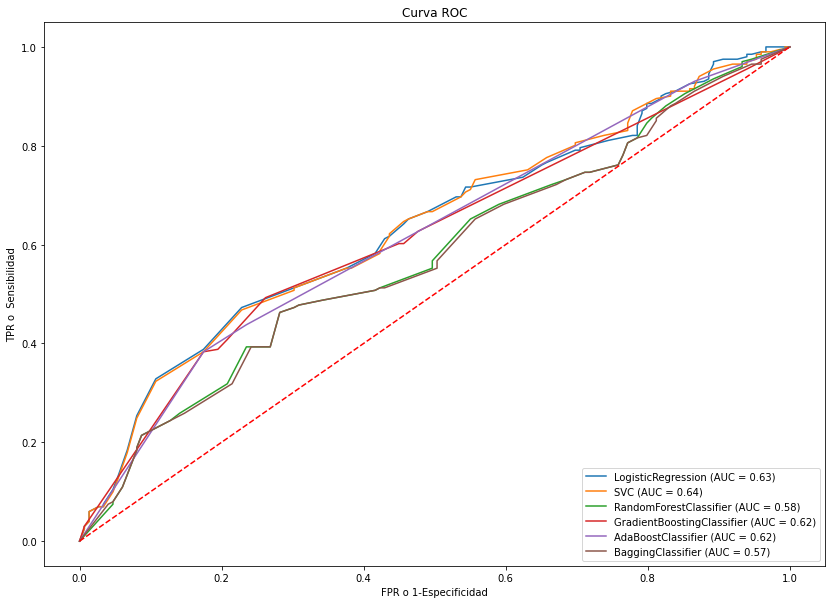

In [25]:
from sklearn.metrics import plot_roc_curve

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)
ax=plt.gca()
# LogisticRegression
logreg_sklearn = LogisticRegression()
logreg_sklearn.fit(X_train, y_train)
logreg_sklearn_roc = plot_roc_curve(logreg_sklearn, X_test, y_test, ax=ax)
# SVC (Support Vector Classification)
svc_sklearn = SVC(random_state=2021)
svc_sklearn.fit(X_train, y_train)
svc_sklearn_roc = plot_roc_curve(svc_sklearn, X_test, y_test, ax=ax)
# RandomForestClassifier
rfc_sklearn = RandomForestClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
rfc_sklearn.fit(X_train, y_train)
rfc_sklearn_roc = plot_roc_curve(rfc_sklearn, X_test, y_test, ax=ax)
# GradientBoostingClassifier
gbc_sklearn = GradientBoostingClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
gbc_sklearn.fit(X_train, y_train)
gbc_sklearn_roc = plot_roc_curve(gbc_sklearn, X_test, y_test, ax=ax)
# AdaBoostClassifier
abc_sklearn = AdaBoostClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
abc_sklearn.fit(X_train, y_train)
abc_sklearn_roc = plot_roc_curve(abc_sklearn, X_test, y_test, ax=ax)
# BaggingClassifier
bgc_sklearn =BaggingClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
bgc_sklearn.fit(X_train, y_train)
bgc_sklearn_roc = plot_roc_curve(bgc_sklearn, X_test, y_test, ax=ax)

plt.title("Curva ROC")
plt.ylabel("TPR o  Sensibilidad")
plt.xlabel("FPR o 1-Especificidad")
plt.plot([0, 1], [0, 1],'r--')
rcParams['figure.figsize'] = 16, 10
# plt.rcParams["figure.figsize"] = (12, 12)
plt.show()

In [26]:
# Scores.
score_lr     = round(logreg_sklearn.score(X_test, y_test), 5)
score_svc = round(svc_sklearn.score(X_test, y_test), 5)
score_rfc  = round(rfc_sklearn.score(X_test, y_test), 5)
score_gbc = round(gbc_sklearn.score(X_test, y_test), 5)
score_abc = round(abc_sklearn.score(X_test, y_test), 5)
score_bgc = round(bgc_sklearn.score(X_test, y_test), 5)
# Asignar datos de la lista.  
results = {'Model': ['LogisticRegression', 'SVC (SupportVectorClassifier)', 'RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'BaggingClassifier'],
               'Score': [score_lr, score_svc, score_rfc, score_gbc, score_abc, score_bgc]}  
# Crear DataFrame .
df_results = pd.DataFrame(results)  
# Imprimir listado de Scores.  
df_results.sort_values(by=['Score'], ascending=False, ignore_index=True)

,Model,Score
0,SVC (SupportVectorClassifier),0.58857
1,AdaBoostClassifier,0.57714
2,LogisticRegression,0.57429
3,GradientBoostingClassifier,0.57429
4,RandomForestClassifier,0.55714
5,BaggingClassifier,0.55429


In [27]:
# Scores CV.
score_lr_cv     = round(cross_val_score(logreg_sklearn, X, y, cv=10).mean(), 5)
score_svc_cv = round(cross_val_score(svc_sklearn, X, y, cv=10).mean(), 5)
score_rfc_cv  = round(cross_val_score(rfc_sklearn, X, y, cv=10).mean(), 5)
score_gbc_cv = round(cross_val_score(gbc_sklearn, X, y, cv=10).mean(), 5)
score_abc_cv = round(cross_val_score(abc_sklearn, X, y, cv=10).mean(), 5)
score_bgc_cv = round(cross_val_score(bgc_sklearn, X, y, cv=10).mean(), 5)
# Asignar datos de la lista.   
results_cv = {'Model': ['LogisticRegression', 'SVC (SupportVectorClassifier)', 'RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'BaggingClassifier'],
               'Score CV 10': [score_lr_cv, score_svc_cv, score_rfc_cv, score_gbc_cv, score_abc_cv, score_bgc_cv]}  
# Crear DataFrame .
df_results_cv = pd.DataFrame(results_cv)  
# Imprimir listado de Scores CV.  
df_results_cv.sort_values(by=['Score CV 10'], ascending=False, ignore_index=True)

,Model,Score CV 10
0,AdaBoostClassifier,0.58962
1,BaggingClassifier,0.58958
2,RandomForestClassifier,0.58872
3,SVC (SupportVectorClassifier),0.58193
4,LogisticRegression,0.58027
5,GradientBoostingClassifier,0.56394
